# Remove data from 9/11

In [1]:
# execute if not installed
import sys
import os 
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
data_path = 'data/finance_datasets/stock_data/'
df_list = []
cols = []
for fname in os.listdir(data_path):
    df = pd.read_csv(data_path + fname)
    df['Date'] = pd.to_datetime(df['Date'])
    cols.append(fname)
    df_list.append(df)

cols = [w.split('.')[0] for w in cols]

 2001-05-29 y 2001-12-25

In [5]:
date_start = np.datetime64('2001-05-29')
date_end = np.datetime64('2001-12-25')


for i, df in enumerate(df_list):
    idx = (df['Date'] >= date_start) & (df['Date'] <= date_end)
    df_list[i] = df.loc[idx, :][['Date', 'Adj Close']]
    # df_list[i].set_index('Date', inplace=True)
    df_list[i]['Day'] = (df_list[i]['Date'] - df_list[i]['Date'].iloc[0]).dt.days.values
    print(df_list[i].shape)

(143, 3)
(143, 3)
(143, 3)
(143, 3)
(143, 3)
(143, 3)
(143, 3)
(143, 3)
(143, 3)


In [6]:
data = []
for df in df_list:
    data.append(mogptk.Data(X=df['Day'].values, Y=df['Adj Close'].values))
    
for d in data:
    d.transform(mogptk.TransformDetrend)

In [7]:
# randomly sample from the data
# for channel in data:
#     channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure

data[0].remove_range(df['Day'].iloc[-1], None)

for i in range(2, len(cols)):
     data[i].remove_range(100, 130)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df_list[i]['Adj Close'].values[~data[i].mask] for i in range(len(cols))]

## Likelihood

In [8]:
like = None
like_params = {}

#  MOSM

In [9]:
%%time
n_trials = 5

mosm_list = []
mosm_mae = np.zeros((n_trials, len(df_list)))
mosm_mape = np.zeros((n_trials, len(df_list)))
mosm_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=4)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B',
                     maxiter=4000,
                     tol=1e-50,
                     # likelihood=like,
                     variational=True,
                     # like_params=like_params,
                    )
    print('Finished trial', n)
    print('='*50)        
    mosm_list.append(model_mosm)
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1182.465088
  Number of iterations: 4000
  Number of functions evaluations: 4300
Done in  28.30059810876846  minutes
Finished trial 0
CPU times: user 36min 6s, sys: 3min 24s, total: 39min 31s
Wall time: 30min 37s


In [10]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.157766,0.657518,0.157766,0.0,0.0,0.0
1,0.834558,4.206071,0.957597,0.0,0.0,0.0
2,0.280585,1.346119,0.329721,0.0,0.0,0.0
3,1.719698,10.180860,1.890405,0.0,0.0,0.0
4,2.156996,6.591054,2.582419,0.0,0.0,0.0
5,2.043729,15.098637,2.375554,0.0,0.0,0.0
6,45.250850,4.249846,57.663451,0.0,0.0,0.0
7,1.372522,7.540658,1.810255,0.0,0.0,0.0
8,29.946080,9.088788,35.967996,0.0,0.0,0.0


In [ ]:
best_model = mosm_list[np.argmin(mosm_mape.mean(1))]
mogptk.plot_prediction(model_csm, grid=(3, 3), names=cols, title='Stocks CSM');

best_model = mosm_list[np.argmin(mosm_mape.mean(1))]

ylims = [(22, 28), (19, 23), (18, 24),
         (18, 23), (32, 41), (14, 22),
         (1000, 1300), (18, 27), (300, 500)]
f, axarr = mogptk.plot_prediction(model_mosm,
                       grid=(3, 3),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

yticks = [(22, 28), (19, 23), (18, 24),
         (18, 23), (32, 41), (14, 22),
         (1000, 1300), (18, 27), (300, 500)]
for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=13)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))


# CSM

In [12]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(df_list)))
csm_mape = np.zeros((n_trials, len(df_list)))
csm_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=4)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B',
                    maxiter=4000,
                    tol=1e-50,
                    likelihood=like,
                    variational=True,
                    like_params=like_params)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1924.212258
  Number of iterations: 4000
  Number of functions evaluations: 4387
Done in  13.108392210801442  minutes
Finished trial 0
CPU times: user 20min 39s, sys: 2min 27s, total: 23min 7s
Wall time: 14min 41s


In [13]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.453598,1.890456,0.453598,0.0,0.0,0.0
1,0.621296,3.036467,0.805422,0.0,0.0,0.0
2,0.399045,1.894020,0.525513,0.0,0.0,0.0
3,1.380004,8.168505,1.482695,0.0,0.0,0.0
4,2.015446,6.192831,2.480978,0.0,0.0,0.0
5,2.614260,19.235018,2.915990,0.0,0.0,0.0
6,45.499023,4.232344,53.964372,0.0,0.0,0.0
7,0.835973,4.564626,1.051183,0.0,0.0,0.0
8,17.175834,5.004900,19.636732,0.0,0.0,0.0


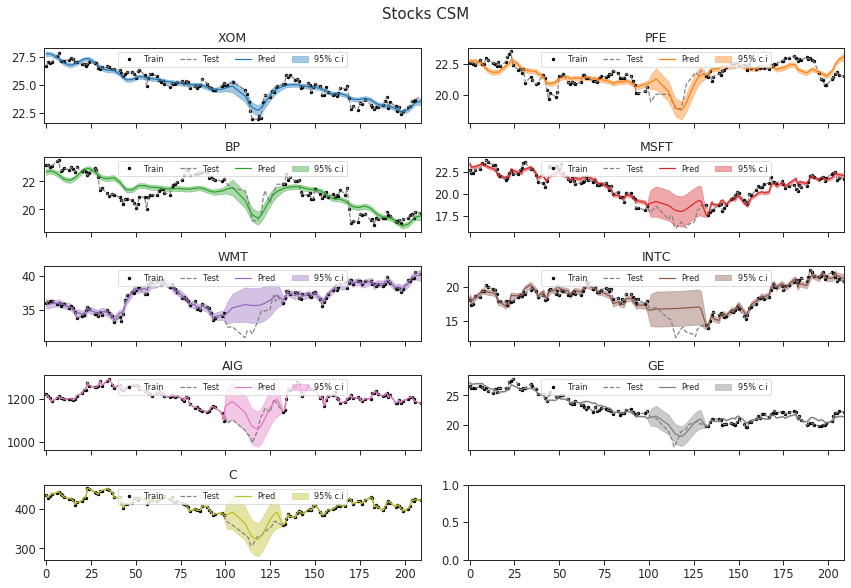

In [14]:
mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Stocks CSM');

# SM-LMC

In [15]:
%%time
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(df_list)))
smlmc_mape = np.zeros((n_trials, len(df_list)))
smlmc_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=4)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.train(method='L-BFGS-B',
                      maxiter=4000,
                      tol=1e-50,
                      likelihood=like,
                      variational=True,
                      like_params=like_params)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1777.442264
  Number of iterations: 2578
  Number of functions evaluations: 2676
Done in  7.406608426570893  minutes
CPU times: user 13min 35s, sys: 1min 36s, total: 15min 12s
Wall time: 8min 53s


In [16]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE%,RMSE,MAE std,MAPE% std,RMSE std
0,0.665665,2.774283,0.665665,0.0,0.0,0.0
1,0.659703,3.278160,0.721847,0.0,0.0,0.0
2,0.434299,2.081974,0.573387,0.0,0.0,0.0
3,2.630009,15.718672,3.053112,0.0,0.0,0.0
4,2.501355,7.624123,2.927046,0.0,0.0,0.0
5,4.765858,34.894024,5.528108,0.0,0.0,0.0
6,60.171778,5.703598,78.287771,0.0,0.0,0.0
7,1.849262,10.184136,2.415646,0.0,0.0,0.0
8,48.842723,14.707500,55.316491,0.0,0.0,0.0


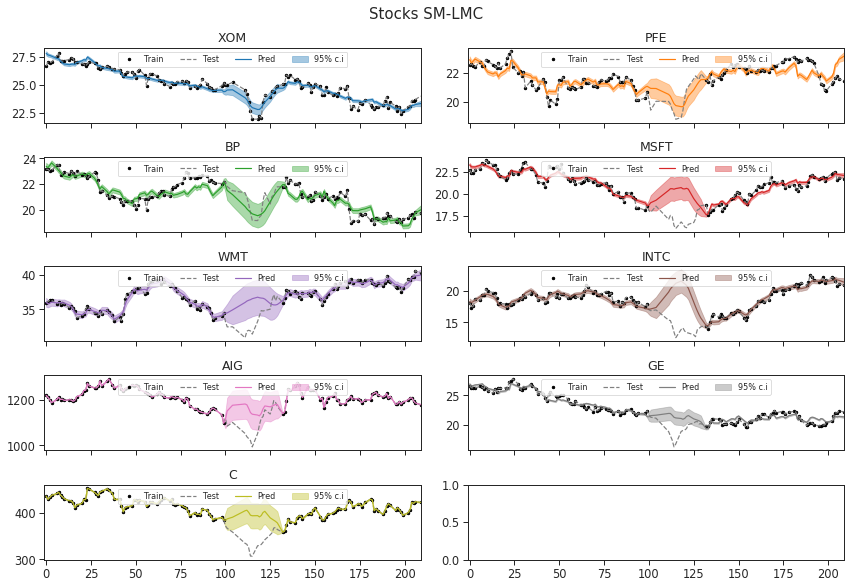

In [17]:
mogptk.plot_prediction(model_smlmc, grid=(5, 2), names=cols, title='Stocks SM-LMC');

# Comparison

In [18]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean())

7.287754028128658 6.541088898125896 11.774023283214444
